In [13]:
%pip install matplotlib
%pip install tensorflow

import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [24]:
def plot_metrics(history):
  
  metrics = ['loss', 'prc', 'precision', 'recall']

  for n, metric in enumerate(metrics):
    name = metric.replace("_", " ").capitalize()

    plt.subplot(2, 2, n+1)
    plt.plot(
        np.arange(len(history[metric])),
        history[metric],
        color='lightcoral',
        label='Train'
    )
    plt.plot(
        np.arange(len(history[metric])),
        history['val_'+metric],
        color='lightcoral',
        linestyle="--",
        label='Val'
    )

    plt.xlabel('Epoch')
    plt.ylabel(name)

    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.6, 1])
    else:
      plt.ylim([0, 1])

    plt.legend()
    plt.tight_layout()
    plt.savefig('../reports/figures/resnet50_transfer_learning_paad_5x.pdf')


In [15]:
tf.__version__
with open("../models/resnet50_transfer_learning_paad_5x_v2/history.pkl", "rb") as f:
  history = pickle.load(f)

C:\Users\jacks\AppData\Local\Temp/ipykernel_712/3554811447.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\jacks\AppData\Local\Temp/ipykernel_712/3554811447.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\jacks\AppData\Local\Temp/ipykernel_712/3554811447.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


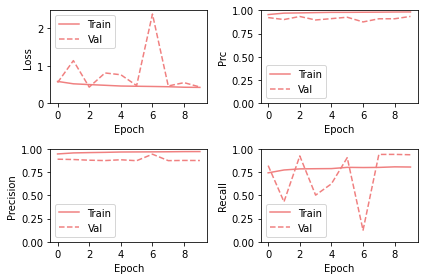

In [25]:
plot_metrics(history)
plt.show()

In [26]:
METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR')  # Precision-recall curve
]
STEPS_PER_EPOCH = 254

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = tf.keras.Sequential()

  # Create a ResNet50 layer with the last 15 layers unfrozen
  resnet = tf.keras.applications.ResNet50(
       include_top=False,
       pooling='avg',
       weights='imagenet'
  )
  for layer in resnet.layers[:-15]:
    layer.trainable = False

  model.add(resnet)

  # Add an activation layer meant for binary classification with a kernel
  # regularizer to prevent overfitting.
  model.add(tf.keras.layers.Dense(
      1,
      activation='sigmoid',
      bias_initializer=output_bias,
      kernel_regularizer=tf.keras.regularizers.l2(0.001)
  ))

  # Add a decaying learning rate over time to reduce overfitting.
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      0.0005,
      decay_steps=STEPS_PER_EPOCH*1000,
      decay_rate=1,
      staircase=False
  )

  # Compile the model.
  model.compile(
      optimizer=tf.keras.optimizers.Adam(lr_schedule),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=metrics
  )

  return model

model = make_model()
model.load_weights('../models/paad_classifier_v1/weights-19.h5')

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

# Create data generator
datagen = ImageDataGenerator(
    rescale=1/255,
    preprocessing_function=preprocess_input,
    rotation_range=20,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    height_shift_range=0.2,
    shear_range=20
)

# Testing dataset
test_ds = datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=64
)


In [ ]:
# Evaluate model
eval_result = model.evaluate(
    test_ds,
    steps=len(test_ds)
)
